In [1]:
import pandas as pd
import numpy as np
from readFile import split_into_values, toRPdata
# columns 와 value는 사용자 입력
df = pd.read_csv('resources/AXISX_resample.csv')
# df = pd.read_csv('resources/CLAMP_resample.csv')
columns = ['chip', 'wire', 'segment']
value = ['value']
#df = pd.read_csv('resources/Dataset1.csv')
#columns = ['Process', 'Step']
#value = ['Value']

df = df.loc[:, columns + value] #('chip', 'wire', 'value')는 사용자 입력
size = 96
result = split_into_values(df, columns)

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

# 2. 시계열 셋 크기 변경
result_ = TimeSeriesResampler(sz=size).fit_transform(result)

In [98]:
data = result_.reshape(result_.shape[0], 1, size)
# X = toRPdata(data, threshold='point', percentage=30)
X = toRPdata(data)

from sklearn.preprocessing import MinMaxScaler

def MinMax(data):
    MMS = MinMaxScaler().fit(data)
    scaled = MMS.transform(data)
    return scaled

X_scaled = np.empty((X.shape[0], size, size))
for i, data in enumerate(X):
    X_scaled[i] = MinMax(data)
    
X_scaled = np.expand_dims(X_scaled, axis=3)
X_scaled.shape

(1330, 96, 96, 1)

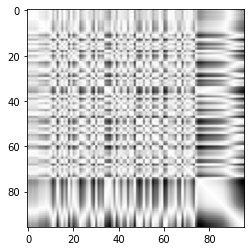

In [99]:
from matplotlib import pyplot as plt
plt.imshow(X[0], cmap='Greys')

In [100]:
#you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable
batch_size = 128
learning_rate = 3e-4
epochs = 10
optimizer='Adam'
loss='binary_crossentropy'

In [112]:
from utils import split_data, normalization_tool
from agent import Autoencoder_Agent
from utils import optimizer_set
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D

X_train, X_test, Y_train, Y_test = split_data(X_scaled, X_scaled) #데이터 분리

optimizer = optimizer_set(optimizer, learning_rate)

model = Sequential()

#1st convolution layer
model.add(Conv2D(32, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
, padding='same', input_shape=(96,96,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(16,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#here compressed version

#4th convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#5th convolution layer
model.add(Conv2D(16,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#6th convolution layer
model.add(Conv2D(32,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))
model.summary()

#학습(약 7000번 정도 진행)
model.compile(optimizer=optimizer, loss=loss, metrics=['poisson']) #사용자 지정 파라미터(optimizer, loss)

# metrics 에서 accuracy 는 본래 회귀문제에서(연속적인 값을 예측하는 문제) 사용되는 metric은 아니다. (분류 문제에서 사용됨)
# Keras 는 이를 Binary Accuracy 개념으로 바꾸어, 실제 값과 예측값의 차이값에서 동일한 값을 가지는 것과 틀린것의 비율을 구한다고 볼 수 있다.
# 따라서, RP의 값이 1, 0으로 나누어진 흑백에서는 잘 통할 수 있으나(Binary_accuracy)
# RP값이 연속적일 경우에는 다른 metrics을 알아보아야 한다.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_42 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 48, 48, 16)        4624      
_________________________________________________________________
activation_43 (Activation)   (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 24, 2)        

In [113]:
hist = model.fit(X_train, X_train,
          validation_split=0.25,
          batch_size = batch_size,epochs=epochs,
          validation_data=(X_test,X_test),
         )

Epoch 1/10
8/8 [==============================] - 1s 97ms/step - loss: 0.6916 - poisson: 0.8056 - val_loss: 0.6881 - val_poisson: 0.8001
Epoch 2/10
8/8 [==============================] - 1s 73ms/step - loss: 0.6857 - poisson: 0.8024 - val_loss: 0.6829 - val_poisson: 0.7971
Epoch 3/10
8/8 [==============================] - 1s 73ms/step - loss: 0.6814 - poisson: 0.8000 - val_loss: 0.6778 - val_poisson: 0.7943
Epoch 4/10
8/8 [==============================] - 1s 73ms/step - loss: 0.6749 - poisson: 0.7962 - val_loss: 0.6690 - val_poisson: 0.7890
Epoch 5/10
8/8 [==============================] - 1s 73ms/step - loss: 0.6641 - poisson: 0.7898 - val_loss: 0.6583 - val_poisson: 0.7831
Epoch 6/10
8/8 [==============================] - 1s 75ms/step - loss: 0.6538 - poisson: 0.7845 - val_loss: 0.6481 - val_poisson: 0.7781
Epoch 7/10
8/8 [==============================] - 1s 73ms/step - loss: 0.6443 - poisson: 0.7797 - val_loss: 0.6393 - val_poisson: 0.7733
Epoch 8/10
8/8 [=========================

In [104]:
hist.history

{'loss': [0.6925374269485474,
  0.6907572746276855,
  0.6889448761940002,
  0.6869408488273621,
  0.6845901012420654,
  0.6820393800735474,
  0.6787958145141602,
  0.6738821268081665,
  0.6665129065513611,
  0.6564928889274597],
 'cosine_similarity': [0.9895789623260498,
  0.9895788431167603,
  0.9895788431167603,
  0.9895789623260498,
  0.9895789623260498,
  0.9895789623260498,
  0.9895789623260498,
  0.9895788431167603,
  0.9895789623260498,
  0.9895789623260498],
 'val_loss': [0.6915364861488342,
  0.6896308660507202,
  0.6877333521842957,
  0.6855025887489319,
  0.6830302476882935,
  0.6802668571472168,
  0.6764136552810669,
  0.6707027554512024,
  0.6620753407478333,
  0.6528530716896057],
 'val_cosine_similarity': [0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394,
  0.9895790815353394]}

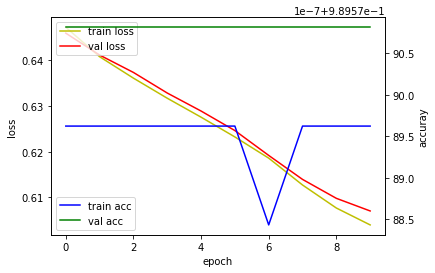

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['cosine_similarity'], 'b', label='train acc')
acc_ax.plot(hist.history['val_cosine_similarity'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [97]:
y_pred = model.predict(X_test)
# print(y_pred[0])
# print(X_test.shape)
# print(((np.round(y_pred[0]) == X_test[0]) + (np.round(y_pred[1]) == X_test[1]))/ 2)
l = len(X_test)
acc = sum([np.round(y_pred[i])==X_test[i] for i in range(l)])/l
# acc = sum([y_pred[i]==X_test[i] for i in range(l)])/l
np.mean(acc)

0.010417318360026693

In [90]:
y_pred[0]
X_test[0]

array([[[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]])

In [72]:
lst1 = np.array([[[[1],[2]], [[1],[2]]], [[[1],[2]], [[1],[2]]]])
lst2 = np.array([[[[1],[2]], [[1],[4]]], [[[1],[4]], [[1],[2]]]])

print(sum([lst1[i] == lst2[i] for i in range(2)]))
#

[[[2]
  [1]]

 [[2]
  [1]]]


In [32]:
from keras import backend as K
get_layer_output = K.function([model.layers[0].input],[model.layers[8].output])
compressed = get_layer_output([X_train])[0]
feature = compressed.reshape(compressed.shape[0], compressed.shape[1]*compressed.shape[2]*compressed.shape[3])
print(feature)
print(feature.shape)

[[0.         0.7288813  0.         ... 0.19060244 0.01965969 0.27075973]
 [0.27627707 0.23691434 0.12823673 ... 0.4054701  0.13754071 0.16189253]
 [0.1528883  0.5069024  0.         ... 0.17404582 0.00574959 0.20704743]
 ...
 [0.01133747 0.60169214 0.         ... 0.12990808 0.15640005 0.11846576]
 [0.         0.72082096 0.         ... 0.33408728 0.         0.40843672]
 [0.36388862 0.22455132 0.03131079 ... 0.5912214  0.08734117 0.01690575]]
(997, 288)
